In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)

import numpy as np
import pandas as pd
import skforecast

print(skforecast.__version__)

/home/joaquin/Documents/GitHub/skforecast
0.20.0


In [2]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import skforecast
from skforecast.stats import Sarimax, Arima
from skforecast.recursive import ForecasterStats
from skforecast.model_selection import TimeSeriesFold, backtesting_stats
from skforecast.plot import set_dark_theme
from skforecast.datasets import fetch_dataset

from aeon.forecasting.stats import ARIMA as ARIMA_aeon
from statsforecast import StatsForecast
from statsforecast.models import ARIMA as ARIMA_statsforecast
import matplotlib.pyplot as plt
import timeit

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
print(f"skforecast version: {skforecast.__version__}")

skforecast version: 0.20.0


# Fuel consumption dataset

In [3]:
# Download data
# ==============================================================================
data = fetch_dataset(name='fuel_consumption', raw=True, verbose=False)
data = data[['Fecha', 'Gasolinas']]
data = data.rename(columns={'Fecha': 'date', 'Gasolinas': 'y'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.loc[:'1990-01-01 00:00:00', ['y']]
data['month'] = data.index.month
data = pd.get_dummies(data, columns=['month'], prefix='month', drop_first=False, dtype=float)
data.head(3)

,y,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,
1969-01-01,166875.2129,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1969-02-01,155466.8105,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1969-03-01,184983.6699,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Simula una serie temporal para un ARIMA(1, 1, 1)
np.random.seed(123)
n = 200
e = np.random.normal(0, 1, n)

# Generar ARMA(1,1)
w = np.zeros(n)
for t in range(1, n):
    w[t] = 0.5 * w[t-1] + e[t] + 0.8 * e[t-1]

# Integrar para I(1)
y = np.cumsum(w)
data = pd.DataFrame({'y': y}, index=data.index[:n])
data.head(3)

,y
date,
1969-01-01,0.000000
1969-02-01,0.128841
1969-03-01,1.274116


Train dates : 1969-01-01 00:00:00 --- 1980-01-01 00:00:00  (n=133)
Test dates  : 1980-02-01 00:00:00 --- 1985-08-01 00:00:00  (n=67)


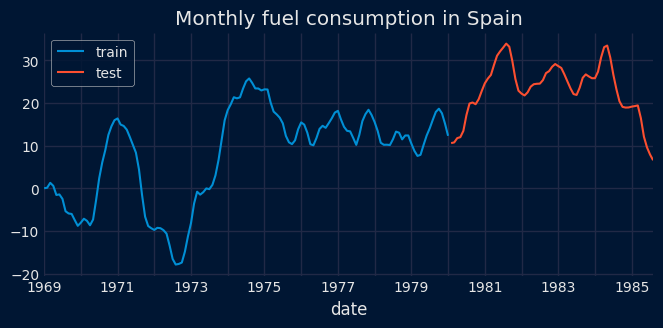

In [5]:
# Train-test dates
# ======================================================================================
set_dark_theme()
end_train = '1980-01-01 23:59:59'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.loc[:].index.max()}  "
    f"(n={len(data.loc[end_train:])})"
)
data_train = data.loc[:end_train]
data_test  = data.loc[end_train:]

# Plot
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.set_title('Monthly fuel consumption in Spain')
ax.legend();

# Compare ets from skforecast, aeon, statsforecast and statsmodels

In [6]:
order = (1, 1, 1)
seasonal_order = (0, 0, 0)
m = 1

In [7]:
# ARIMA skforecast
# ==============================================================================
forecaster = ForecasterStats(
                estimator = Arima(
                    order=order,
                    seasonal_order=seasonal_order,
                    m = m
                )
            )
start = timeit.default_timer()
forecaster.fit(y=data_train['y'])
end = timeit.default_timer()
time_fit_arima_skforecast = end - start
print(f"Training time ARIMA skforecast  : {time_fit_arima_skforecast} seconds")
start = timeit.default_timer()
predictions_skforecast = forecaster.predict(steps=24)
end = timeit.default_timer()
time_pred_arima_skforecast = end - start
prediction_intervals_skforecast = forecaster.predict_interval(steps=24, alpha=0.05)
print(f"Prediction time ARIMA skforecast: {time_pred_arima_skforecast} seconds")

Training time ARIMA skforecast  : 0.21529957599977934 seconds
Prediction time ARIMA skforecast: 0.010199897000347846 seconds


/home/joaquin/Documents/GitHub/skforecast/skforecast/stats/arima/_arima_base.py:2469: UserWarning: Possible convergence problem
  warnings.warn("Possible convergence problem")


In [10]:
forecaster.estimators_[0].summary()

ARIMA Model Summary
Model: Arima(1,1,1)
Method: ARIMA(1,1,1)(0,0,0)[1]
Number of observations: 133
Converged: False

Coefficients:
------------------------------------------------------------
  ar1            :     0.4760  (SE:   0.0009, t:   526.47)
  ma1            :     0.8473  (SE:   0.0398, t:    21.28)

Model fit statistics:
  sigma^2:             1.252927
  Log-likelihood:      -202.68
  AIC:                 411.37
  BIC:                 N/A

Residual statistics:
  Mean:                0.018016
  Std Dev:             1.119196
  MAE:                 0.919188
  RMSE:                1.115126

Time Series Summary Statistics:
  Mean:                7.7968
  Std Dev:             11.0640
  Min:                 -17.8945
  25%:                 -0.9225
  Median:              11.4722
  75%:                 15.5366
  Max:                 25.7606


In [12]:
# ARIMA statsmodels
# ==============================================================================
forecaster = ForecasterStats(
                estimator = Sarimax(
                    order=order,
                    seasonal_order=(*seasonal_order, 0)
                )
            )
start = timeit.default_timer()
forecaster.fit(y=data_train['y'])
end = timeit.default_timer()
time_fit_arima_statsmodels = end - start
print(f"Training time ARIMA skforecast  : {time_fit_arima_statsmodels} seconds")
start = timeit.default_timer()
predictions_statsmodels = forecaster.predict(steps=24)
end = timeit.default_timer()
time_pred_arima_statsmodels = end - start
prediction_intervals_statsmodels = forecaster.predict_interval(steps=24, alpha=0.05)
print(f"Prediction time ARIMA skforecast: {time_pred_arima_statsmodels} seconds")

Training time ARIMA skforecast  : 0.04064337899944803 seconds
Prediction time ARIMA skforecast: 0.004818106999664451 seconds


In [13]:
forecaster.estimators_[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  133
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -202.504
Date:                Wed, 07 Jan 2026   AIC                            411.007
Time:                        17:59:01   BIC                            419.656
Sample:                    01-01-1969   HQIC                           414.522
                         - 01-01-1980                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4719      0.084      5.606      0.000       0.307       0.637
ma.L1          0.8538      0.052     16.411      0.000       0.752       0.956
sigma2         1.2379      0.180      6.880      0.000       0.885       1.591
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 1.76
Prob(Q):                              0.75   Prob(JB):                         0.41
Heteroskedasticity (H):               0.85   Skew:                             0.02
Prob(H) (two-sided):                  0.61   Kurtosis:                         2.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [74]:
# ARIMA aeon
# ==============================================================================
# Aeeon ARIMA do not support seasonality nor prediction intervals
forecaster = ForecasterStats(
                 estimator=ARIMA_aeon(p=order[0], d=order[1], q=order[2])   
             )
start = timeit.default_timer()
forecaster.fit(y=data_train['y'])
end = timeit.default_timer()
time_fit_arima_aeon = end - start
print(f"Training time ARIMA aeon  : {time_fit_arima_aeon} seconds")
start = timeit.default_timer()
predictions_aeon = forecaster.predict(steps=24)
end = timeit.default_timer()
time_pred_arima_aeon = end - start
print(f"Prediction time ARIMA aeon: {time_pred_arima_aeon} seconds")

Training time ARIMA aeon  : 0.004577498999879026 seconds
Prediction time ARIMA aeon: 0.00479460900032791 seconds


In [75]:
# Nixtla StatsForecast Arima
# ==============================================================================
df_nixtla = data_train['y'].reset_index()
df_nixtla.columns = ['ds', 'y']
df_nixtla['unique_id'] = 'fuel'

start = timeit.default_timer()
sf = StatsForecast(
    models=[ARIMA_statsforecast(order=order, seasonal_order=seasonal_order, season_length=m)],
    freq='MS'
)
sf.fit(df=df_nixtla)
end = timeit.default_timer()
time_fit_arima_nixtla = end - start
print(f"Training time ARIMA nixtla  : {time_fit_arima_nixtla} seconds")

start = timeit.default_timer()
predictions_nixtla_df = sf.predict(h=24, level=[95])
end = timeit.default_timer()
time_pred_arima_nixtla = end - start

# Extract predictions and prediction intervals
predictions_nixtla = predictions_nixtla_df['ARIMA'].values
predictions_nixtla = pd.Series(predictions_nixtla, index=pd.date_range(start=data_test.index[0], periods=24, freq='MS'))

prediction_intervals_nixtla = pd.DataFrame({
    'lower_bound': predictions_nixtla_df['ARIMA-lo-95'].values,
    'upper_bound': predictions_nixtla_df['ARIMA-hi-95'].values
}, index=predictions_nixtla.index)

print(f"Prediction time ARIMA nixtla: {time_pred_arima_nixtla} seconds")

Training time ARIMA nixtla  : 0.15358240300020043 seconds
Prediction time ARIMA nixtla: 0.01198870000007446 seconds


In [76]:
# Table of times
# ==============================================================================
times_arima = pd.DataFrame({
    'fit_time_seconds': [time_fit_arima_skforecast, time_fit_arima_aeon, time_fit_arima_nixtla, time_fit_arima_statsmodels],
    'predict_time_seconds': [time_pred_arima_skforecast, time_pred_arima_aeon, time_pred_arima_nixtla, time_pred_arima_statsmodels]
}, index=['ARIMA skforecast', 'ARIMA aeon', 'ARIMA nixtla', 'ARIMA statsmodels'])
times_arima.sort_values(by='fit_time_seconds')

,fit_time_seconds,predict_time_seconds
ARIMA aeon,0.004577,0.004795
ARIMA statsmodels,0.087972,0.008444
ARIMA skforecast,0.098260,0.001668
ARIMA nixtla,0.153582,0.011989


,skforecast,aeon,nixtla,statsmodels
1980-02-01,0.0,10.348882,10.365213,10.365651
1980-03-01,0.0,9.415815,9.452030,9.451590
1980-04-01,0.0,8.970162,9.021572,9.020206


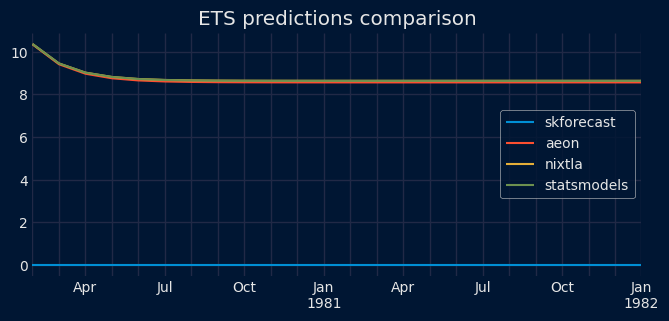

In [77]:
# compare predictions
# ======================================================================================
predictions = pd.DataFrame({
    'skforecast': predictions_skforecast,
    'aeon'      : predictions_aeon,
    'nixtla'    : predictions_nixtla,
    'statsmodels': predictions_statsmodels
})
display(predictions.head(3))
predictions.plot(figsize=(7, 3), title='ETS predictions comparison');

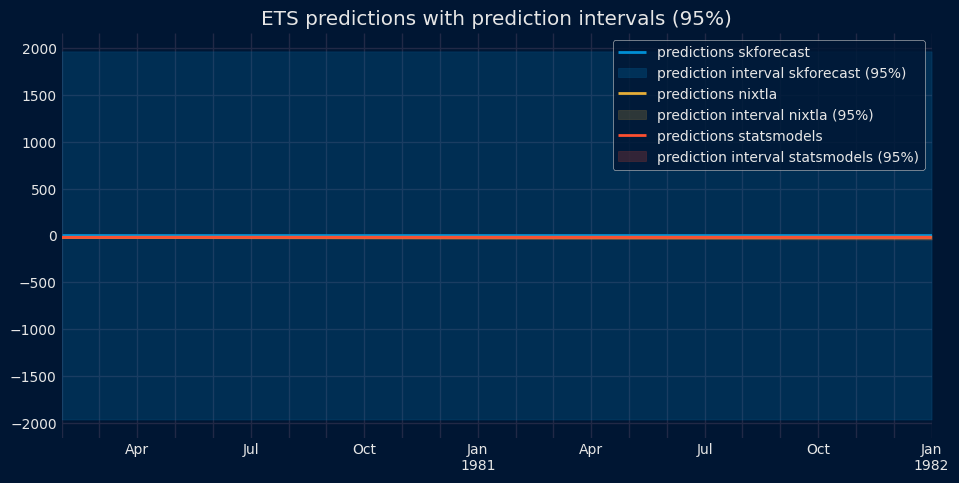

In [60]:
# Plot predictions with prediction intervals
# ======================================================================================
fig, ax = plt.subplots(figsize=(10, 5))

# Skforecast
predictions_skforecast.plot(ax=ax, label='predictions skforecast', color='C0', linewidth=2)
ax.fill_between(
    prediction_intervals_skforecast.index,
    prediction_intervals_skforecast['lower_bound'],
    prediction_intervals_skforecast['upper_bound'],
    color='C0',
    alpha=0.2,
    label='prediction interval skforecast (95%)'
)

# Nixtla
predictions_nixtla.plot(ax=ax, label='predictions nixtla', color='C2', linewidth=2)
ax.fill_between(
    prediction_intervals_nixtla.index,
    prediction_intervals_nixtla['lower_bound'],
    prediction_intervals_nixtla['upper_bound'],
    color='C2',
    alpha=0.2,
    label='prediction interval nixtla (95%)'
)

# Statsmodels
predictions_statsmodels.plot(ax=ax, label='predictions statsmodels', color='C1', linewidth=2)
ax.fill_between(
    prediction_intervals_statsmodels.index,
    prediction_intervals_statsmodels['lower_bound'],
    prediction_intervals_statsmodels['upper_bound'],
    color='C1',
    alpha=0.2,
    label='prediction interval statsmodels (95%)'
)

ax.set_title('ETS predictions with prediction intervals (95%)')
ax.legend();

In [61]:
# Compare prediction interval widths
# ======================================================================================
interval_widths = pd.DataFrame({
    'skforecast': prediction_intervals_skforecast['upper_bound'] - prediction_intervals_skforecast['lower_bound'],
    'nixtla': prediction_intervals_nixtla['upper_bound'] - prediction_intervals_nixtla['lower_bound'],
    'statsmodels': prediction_intervals_statsmodels['upper_bound'] - prediction_intervals_statsmodels['lower_bound']
})

print("\nPrediction Interval Widths Summary (95% confidence):")
print("=" * 60)
print(interval_widths.describe().T[['mean', 'std', 'min', 'max']])
print("\nAverage interval width:")
print(interval_widths.mean().sort_values())


Prediction Interval Widths Summary (95% confidence):
                    mean        std          min          max
skforecast   3930.912464   0.032592  3930.861083  3930.965635
nixtla         31.391937  11.704874     3.752670    46.565902
statsmodels    30.626923  11.407066     3.666178    45.409139

Average interval width:
statsmodels      30.626923
nixtla           31.391937
skforecast     3930.912464
dtype: float64


In [62]:
# Backtesting ForecasterStats with ETS skforecast
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(data_train),
        refit              = True,
        fixed_train_size   = False,
)
forecaster = ForecasterStats(
                 estimator=Arima(
                     order=(1, 1, 1),
                     seasonal_order=(1, 1, 1),
                     m=12
                 )
             )

start = timeit.default_timer()
metric_ets_skforecast, pred_ets_skforecast = backtesting_stats(
    forecaster = forecaster,
    y          = data['y'],
    cv         = cv,
    metric     = 'mean_absolute_error'
)
stop = timeit.default_timer()
elapsed_time_ets_skforecast = stop - start

/home/joaquin/Documents/GitHub/skforecast/skforecast/stats/arima/_arima_base.py:2469: UserWarning: Possible convergence problem
  warnings.warn("Possible convergence problem")


  0%|          | 0/6 [00:00<?, ?it/s]

/home/joaquin/Documents/GitHub/skforecast/skforecast/stats/arima/_arima_base.py:2469: UserWarning: Possible convergence problem
  warnings.warn("Possible convergence problem")
/home/joaquin/Documents/GitHub/skforecast/skforecast/stats/arima/_arima_base.py:2469: UserWarning: Possible convergence problem
  warnings.warn("Possible convergence problem")
/home/joaquin/Documents/GitHub/skforecast/skforecast/stats/arima/_arima_base.py:2469: UserWarning: Possible convergence problem
  warnings.warn("Possible convergence problem")
/home/joaquin/Documents/GitHub/skforecast/skforecast/stats/arima/_arima_base.py:2469: UserWarning: Possible convergence problem
  warnings.warn("Possible convergence problem")
/home/joaquin/Documents/GitHub/skforecast/skforecast/stats/arima/_arima_base.py:2469: UserWarning: Possible convergence problem
  warnings.warn("Possible convergence problem")


In [63]:
# Backtesting ForecasterStats aeon
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(data_train),
        refit              = True,
        fixed_train_size   = False,
)
forecaster = ForecasterStats(
                 estimator=ARIMA(p=0, d=1, q=12)
             )

start = timeit.default_timer()
metric_ets_aeon, pred_ets_aeon = backtesting_stats(
    forecaster = forecaster,
    y          = data['y'],
    cv         = cv,
    metric     = 'mean_absolute_error'
)
stop = timeit.default_timer()
elapsed_time_ets_aeon = stop - start

NameError: name 'ARIMA' is not defined

In [ ]:
# Backtesting ForecasterStats with ETS nixtla
# ==============================================================================
# Note: Nixtla's StatsForecast doesn't integrate directly with skforecast's backtesting
# For a fair comparison, we would need to implement custom backtesting for nixtla
print("Note: Nixtla StatsForecast backtesting would require custom implementation")

Note: Nixtla StatsForecast backtesting would require custom implementation


In [ ]:
# Results
# ==============================================================================
results = pd.DataFrame(
    {
        "Model": [
            "Ets skforecast",
            "ETS aeon",
        ],
        "MAE": [
            
            metric_ets_skforecast.at[0, "mean_absolute_error"],
            metric_ets_aeon.at[0, "mean_absolute_error"],
        ],
        "Elapsed Time (s)": [
            elapsed_time_ets_skforecast,
            elapsed_time_ets_aeon,
        ],
    }
)
results = results.sort_values(by="MAE").reset_index(drop=True)
results

,Model,MAE,Elapsed Time (s)
0,ETS aeon,47676.347177,0.072311
1,Ets skforecast,537475.735647,3.326158


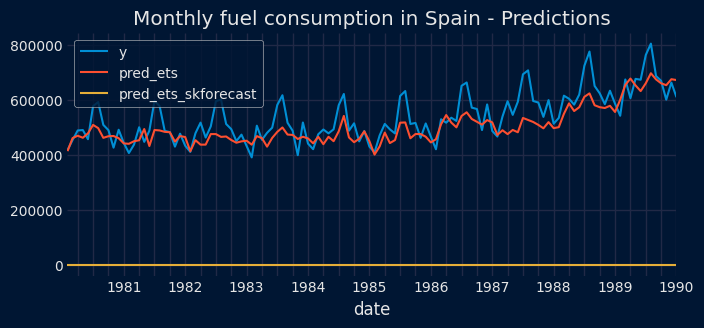

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data['y'].loc[data_test.index].plot(ax=ax, label='y')
pred_ets_aeon['pred'].plot(ax=ax, label='pred_ets')
pred_ets_skforecast['pred'].plot(ax=ax, label='pred_ets_skforecast')
ax.set_title('Monthly fuel consumption in Spain - Predictions')
ax.legend();